# Netatmo data processing

In [ ]:
import glob
from os import path

import contextily as cx
import geopandas as gpd
import seaborn as sns
from uhi_drivers_lausanne import netatmo_utils, plot_utils

## Load multi-variate data from list of JSON responses

In [ ]:
start_dt = "2021-08-13T07:00"
end_dt = "2021-08-16T07:00"

data_dir = "../data/raw/netatmo"
agglom_extent_filepath = "../data/raw/agglom-extent/agglom-extent.shp"
dst_ts_df_filepath = "../data/interim/netatmo/ts-df.csv"
dst_station_gser_filepath = "../data/interim/netatmo/station-gser.gpkg"

In [ ]:
data_filepaths = glob.glob(path.join(data_dir, "*.json"))
agglom_extent_gdf = gpd.read_file(agglom_extent_filepath)

# use the following function to load the data from the JSON files into a pandas data
# frame (time-series of measurements) and a geopandas geo-series (station locations)
ts_df, station_gser = netatmo_utils.process_filepaths(data_filepaths)
# drop stations with the same location (likely due to an incorrect set up that led to
# automatic location assignment based on the IP address of the wireless network) [1]
station_gser = station_gser[~station_gser.duplicated(keep=False)]
# filter stations outside of the agglomeration extent
station_gser = station_gser[station_gser.within(agglom_extent_gdf.to_crs(station_gser.crs).geometry[0])]
# filter time-series to keep only stations in the station geo-series
ts_df = ts_df.loc[:, station_gser.index, start_dt:end_dt]

100%|██████████████████████████████████████████████| 310/310 [00:05<00:00, 57.91it/s]


The number of CWS in the area is:

In [ ]:
len(station_gser)

290

A line plot by station would result in too many lines, therefore we only plot the mean and 95% confidence intervals:

<Axes: xlabel='time', ylabel='value'>

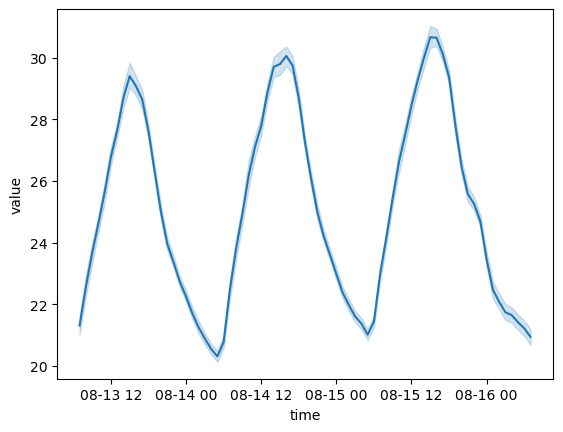

In [ ]:
sns.lineplot(ts_df.loc["temperature"].reset_index(), x="time", y="value")

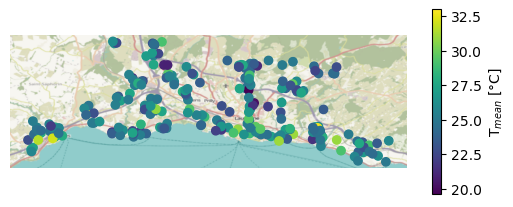

In [ ]:
# plot by average temperature
t_mean_ser = ts_df.loc["temperature"].reset_index().pivot(index="time", columns="id", values="value").mean().rename("T_mean")
plot_kws = {"legend_kwds": {"shrink": 0.5, "label": "T$_{mean}$ [$\degree$C]"}}
_ = plot_utils.plot_stations_by_var(station_gser.loc[t_mean_ser.index], t_mean_ser, edgecolor=None, plot_kws=plot_kws)

In [ ]:
# dump to file
ts_df.to_csv(dst_ts_df_filepath)
station_gser.to_file(dst_station_gser_filepath)

## References

1. 2. Fred Meier, Daniel Fenner, Tom Grassmann, Marco Otto, and Dieter Scherer. Crowdsourcing air temperature from citizen weather stations for urban climate research. *Urban Climate*, 19:170–191, 2017.